# Factor potentials: tagging name tokens

## Objectives and takeaways

1. Provide a case study on how a factor potential can be used in a model to prevent solutions inconsistent with expected model structure.

In this exercise, we will start with an identified model (very simplified) of tagging a sequence of two tokens with its likely form, which can be one of 
`[Surname, GivenName, FirstInitial, LastInitial, Empty]`.

Note that the structure of this exercise is much more complex than exercises we have done before.

### Problem statement

The model receives an input of one or two words or initials and the result should be a set of tags that the model assigns to the words. Example:

- `['John', 'Smith'] --> ['GivenName', 'Surname']`
- `['Sculley', 'Dana'] --> ['Surname', 'GivenName']`
- `['J.', 'Smith'] --> ['FirstInitial', 'Surname']`
- `['Smith', 'J.'] --> ['Surname', 'FirstInitial']`
- `['Smith'] --> ['Surname', 'Empty']`

In our toy version of the problem we are only going to use three features for each token:
- number of characters, int >= 0
- presence of non-alphanumeric characters, 0/1
- list of known words for which we actually have probabilities of them being surnames vs. given names. Of course we frequently do not have a name on our list, so this data can be unobserved.

We first build part of our "knowledge base" and setup a preprocessing function and then introduce the structure of the model.

In [1]:
import theano
import theano.tensor as tt
import pymc3 as pm
import numpy as np

/Users/vejmelka/Packages/anaconda/envs/bayes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# We map the tags into integers for use with PyMC3
token_tags = {'Surname' : 0,
              'GivenName' : 1,
              'FirstInitial' : 2,
              'LastInitial' : 3,
              'Empty' : 4}

We build a probability table that represents the probabilities of the form
`p(name='Gacs'|tag='surname')` under the assumption that the name token is observed, which means it is on our (very short list).

In [3]:
# List of "known names", mapped to integers 0..3
name_mapping = dict(zip(['gacs', 'john', 'smith', 'mark'], range(6)))

In [4]:
# function that maps a labeled example to features.
#
def encode_sample(name_toks):
    fs = []
    for i,(k,v) in enumerate(name_toks):
        fs.append({
            'tag': token_tags[k],
            'length': len(v),
            'has_nonalpha' : 1 if any([not ch.isalnum() for ch in v]) else 0,
            'known_name' : -1 if type(v) != str else name_mapping.get(v.lower(), -1)})

    # add an 'empty' tag if only one token is given
    if len(name_toks) < 2:
        fs.append({'tag' : 4,
                   'length' : 0,
                   'has_nonalpha' : 0,
                   'known_name' : -1})
    return fs


# example
encode_sample([('FirstInitial','J.'), ('Surname', 'Smith')])

[{'has_nonalpha': 1, 'known_name': -1, 'length': 2, 'tag': 2},
 {'has_nonalpha': 0, 'known_name': 2, 'length': 5, 'tag': 0}]

### Model structure

The model (without factor potentials) is structured as shown on the image below

![Without potential](images/tag_model_no_potential.png)

So the posterior probability distribution can be written as

$$f(\text{tag1},\text{tag2} \mid w_1, l_1, a_1, w_2, l_2, a_2) \;\;\; \propto \;\;\; f(w_1 \mid \text{tag1}) \;\;\; f(a_1 \mid \text{tag1}) \;\;\;  f(l_1 \mid \text{tag1}) \;\;\; f(w_2 \mid \text{tag2}) \;\;\; f(a_2 \mid \text{tag2}) \;\;\; f(l_2 \mid \text{tag2}) \;\;\; f(\text{tag1}) \;\;\; f(\text{tag2})$$

We further specify that:
- the `length` of a word has a Poisson distribution with a rate parameter conditional on the tag. The rate parameters are stored as `length_poisson_rate`, an array indexed by tag
- the probability of observing non-alpha numeric characters in a token is Bernoulli with probability $p$ again conditional on the tag, stored as an array `nonalpha_bernoulli_p`.  Non-alphanumeric characters (primarily dot) are expected only in initials and are unexpected in full names.
- if a name is known to us (exists in our shortlist), the probability that we observe it is given by the array `name_prob`.  Thus assuming the tag is GivenName, then observing John is not surprising whereas observing the token Gacs is quite surprising (and thus is assigned low probability).

Note that we assume that this model has already been fitted to some data (some of the values are indeed fitted to data, others are guessed) and we already have the parameters at hand. Those parameters are fitted below.  Please examine the model as written below and study the prior probabilities - check whether they are as you would expect.

### Testing the model
In the cell below are prepared some examples which can be passed to the model.  Uncommenting one sample will execute the model on it.

1. Please carefully examine the outputs and determine if it corresponds to the actual tags or not.
2. In some cases, the model makes an incorrect decision, do you see why when you examine the parameters of the model?
3. How could we fix this?

In [5]:
#data = encode_sample([('Surname', 'Gacs')])
#data = encode_sample([('GivenName', 'John')])
#data = encode_sample([('Surname', 'Gacs'),('GivenName', 'Peter')])
#data = encode_sample([('LastInitial', 'L.'), ('GivenName', 'John')])
data = encode_sample([('Surname', 'Smith'), ('FirstInitial', 'J.')])
data

[{'has_nonalpha': 0, 'known_name': 2, 'length': 5, 'tag': 0},
 {'has_nonalpha': 1, 'known_name': -1, 'length': 2, 'tag': 2}]

Sequential sampling (1 chains in 1 job)
CategoricalGibbsMetropolis: [tag2, tag1]
100%|██████████| 2500/2500 [00:01<00:00, 1773.65it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Ground truth tags: tag1=0 tag2=2


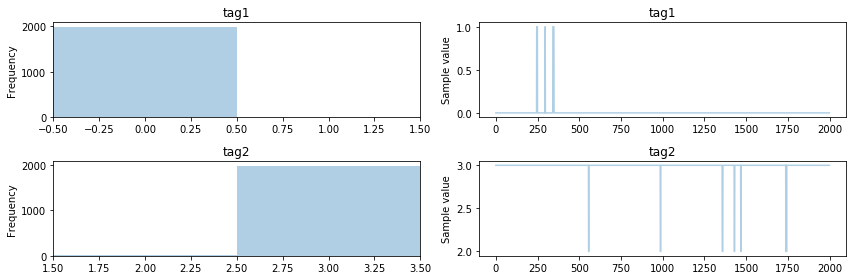

In [6]:
with pm.Model() as name_model:
    
    # priors for specific tokens appearing in slot 1 and slot 2
    tag1 = pm.Categorical('tag1', np.array([0.28, 0.696, 0.02, 0.001, 0.001]))
    tag2 = pm.Categorical('tag2', np.array([0.31, 0.058, 0.002, 0.13, 0.5]))
                        
    # distribution of number of chars
    length_poisson_rate = theano.shared(np.array([6., 6., 1., 1., 0.000001]))
    # distribution of non_alphachars
    nonalpha_bernoulli_p = theano.shared(np.array([0.001, 0.001, 0.8, 0.8, 0.001]))
    # name probabilities for observed names given known tags (see list name_mapping a few cells above)
    # p[1,2] is p(name='Smith'|tag='GivenName')
    name_prob = np.vstack([[0.999, 0.001, 0.999, 0.9, 0.0], #surname
                           [0.001, 0.999, 0.001, 0.1, 0.0], #givenname
                           [0.001, 0.001, 0.001, 0.001, 0.0], #firstinitial
                           [0.001, 0.001, 0.001, 0.001, 0.0], #lastinitial
                           [0.001, 0.001, 0.001, 0.001, 0.001]]) #empty
    known_name_categorical_p = theano.shared(np.array(name_prob))

    # make sure each row adds to one
    name_prob /= np.sum(name_prob, axis=1)[:, np.newaxis]
    name_prob

    len1 = pm.Poisson('len1', length_poisson_rate[tag1], observed = data[0]['length'])
    non_alpha1 = pm.Bernoulli('non_alpha1', nonalpha_bernoulli_p[tag1], observed = data[0]['has_nonalpha'])
    if data[0]['known_name'] >= 0:
        w1 = pm.Categorical('known_word1', known_name_categorical_p[tag1,:], observed = data[0]['known_name'])
        
    len2 = pm.Poisson('len2', length_poisson_rate[tag2], observed = data[1]['length'])
    non_alpha2 = pm.Bernoulli('non_alpha2', nonalpha_bernoulli_p[tag2], observed = data[1]['has_nonalpha'])
    if data[1]['known_name'] >= 0:
        w2 = pm.Categorical('known_word2', known_name_categorical_p[tag2,:], observed = data[1]['known_name'])
    
    tr = pm.sample(draws=2000, tune=500, chains=1)
    
    pm.traceplot(tr)

# and print the actual tags
# reminder: {'Surname' : 0, 'GivenName' : 1,'FirstInitial' : 2, 'LastInitial' : 3, 'Empty' : 4}
print('Ground truth tags: tag1=%d tag2=%d' % (data[0]['tag'], data[1]['tag']))

### Factor potential

We now add a factor potential to the model which is multiplied with the rest of the model, so the full distribution is now:

$$f(\text{tag1},\text{tag2} \mid w_1, l_1, a_1, w_2, l_2, a_2) \;\;\; \propto \;\;\; f(w_1 \mid \text{tag1}) \;\;\; f(a_1 \mid \text{tag1}) \;\;\;  f(l_1 \mid \text{tag1}) \;\;\; f(w_2 \mid \text{tag2}) \;\;\; f(a_2 \mid \text{tag2}) \;\;\; f(l_2 \mid \text{tag2}) \;\;\; f(\text{tag1}) \;\;\; f(\text{tag2}) \;\;\; \mathbf{\Psi(\text{tag1},\text{tag2})}.$$

The new structure of the model is now as shown in the diagram.  The factor potential connects the two tag nodes and introduces a relationship between them that is encoded in the model as specified in the next cells.

![Model with factor potential](images/tag_model_with_potential.png)

Please analyse and try to understand what is the effect of the factor potential by running the examples.

Run the same examples through this model as well and compare the output to the model above.  What is the difference and why is the difference there?

In [7]:
# what data is going into the model? To change this, use the cell above the first model.
data

[{'has_nonalpha': 0, 'known_name': 2, 'length': 5, 'tag': 0},
 {'has_nonalpha': 1, 'known_name': -1, 'length': 2, 'tag': 2}]

Sequential sampling (1 chains in 1 job)
CategoricalGibbsMetropolis: [tag2, tag1]
100%|██████████| 2500/2500 [00:00<00:00, 3044.54it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Ground truth tags: tag1=0 tag2=2


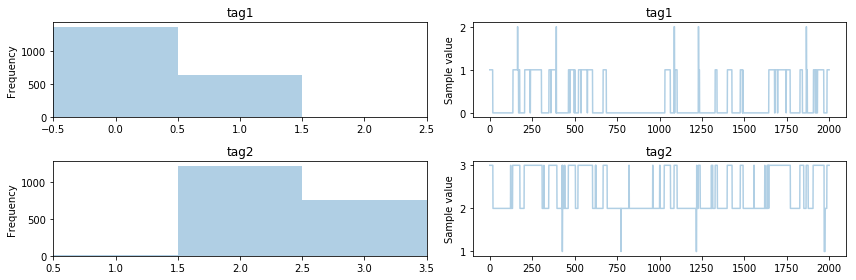

In [8]:
with pm.Model() as name_model:
    
    # priors for specific tokens appearing in slot 1 and slot 2
    tag1 = pm.Categorical('tag1', np.array([0.28, 0.696, 0.02, 0.001, 0.001]))
    tag2 = pm.Categorical('tag2', np.array([0.31, 0.058, 0.002, 0.13, 0.5]))
                        
    # distribution of number of chars
    length_poisson_rate = theano.shared(np.array([6., 6., 1., 1., 0.000001]))
    # distribution of non_alphachars
    nonalpha_bernoulli_p = theano.shared(np.array([0.001, 0.001, 0.8, 0.8, 0.001]))
    # name probabilities for observed names given known tags (see list name_mapping a few cells above)
    # p[1,2] is p(name='Smith'|tag='GivenName')
    name_prob = np.vstack([[0.999, 0.001, 0.999, 0.9, 0.0], #surname
                           [0.001, 0.999, 0.001, 0.1, 0.0], #givenname
                           [0.001, 0.001, 0.001, 0.001, 0.0], #firstinitial
                           [0.001, 0.001, 0.001, 0.001, 0.0], #lastinitial
                           [0.001, 0.001, 0.001, 0.001, 0.001]]) #empty
    known_name_categorical_p = theano.shared(np.array(name_prob))

    # make sure each row adds to one
    name_prob /= np.sum(name_prob, axis=1)[:, np.newaxis]
    name_prob

    len1 = pm.Poisson('len1', length_poisson_rate[tag1], observed = data[0]['length'])
    non_alpha1 = pm.Bernoulli('non_alpha1', nonalpha_bernoulli_p[tag1], observed = data[0]['has_nonalpha'])
    if data[0]['known_name'] >= 0:
        w1 = pm.Categorical('known_word1', known_name_categorical_p[tag1,:], observed = data[0]['known_name'])
        
    len2 = pm.Poisson('len2', length_poisson_rate[tag2], observed = data[1]['length'])
    non_alpha2 = pm.Bernoulli('non_alpha2', nonalpha_bernoulli_p[tag2], observed = data[1]['has_nonalpha'])
    if data[1]['known_name'] >= 0:
        w2 = pm.Categorical('known_word2', known_name_categorical_p[tag2,:], observed = data[1]['known_name'])
    
    # Potential term that encodes interactions between tokens
    # Reminder: 'Surname' : 0, 'GivenName' : 1, 'FirstInitial' : 2, 'LastInitial' : 3, 'Empty' : 4
    potential_p = theano.shared(np.log(np.vstack(
        [[0.001, 0.8, 0.8, 0.001, 0.8],          #surname
         [0.8, 0.001, 0.001, 0.8, 0.8],          #givenname
         [0.8, 0.001, 0.001, 0.8, 0.8],          #firstinitial
         [0.001, 0.8, 0.001, 0.001, 0.8],        #lastinitial
         [0.001, 0.001, 0.001, 0.001, 0.001]]))) #empty
    pm.Potential('potential_p', potential_p[tag1, tag2])
    
    tr = pm.sample(draws=2000, tune=500, chains=1)
    
    pm.traceplot(tr)

# and print the actual tags
# reminder: {'Surname' : 0, 'GivenName' : 1,'FirstInitial' : 2, 'LastInitial' : 3, 'Empty' : 4}
print('Ground truth tags: tag1=%d tag2=%d' % (data[0]['tag'], data[1]['tag']))        

## Conclusions

We have examined the construction of models and the role of different tyes of variable.

One of the building blocks is the factor potential. Factor potentials can establish a structure in the model output and thus eliminate predictions which are not compatible. Factor potentials conceptually introduce a symmetric term (corresponding to an undirected link in the model graph) into the posterior while hierarchical Bayesian terms correspond do directed relationships. We have studied this in two models in detail.